In [39]:
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from codvidutils.Autoencoder_Uncertainty_Transformation_main import Transformation_main
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc
from codvidutils.imageproc import map_categorical
from PIL import Image
from keras.models import load_model

In [2]:
Y_test = []
preds = []
for it in range(5):
    model = 'hdf_files/Uncertainty_AE_Covid_{}.hdf5'.format(it+1)
    outputs = Transformation_main('data/train_split_v4.csv', 'data/test_split_v5.csv', model)
    Y_test = outputs['Y_test']
    preds += [np.loadtxt('log/preds_XGBr_Uncertainty_{}.txt'.format(it+1), delimiter=',')]
    del outputs

You are going to read from: data/train_split_v4.csv and data/test_split_v5.csv
Total number of images: 1524
shape X: 13600 1524,  disease_ID (Y): 13600 1524
Count of classes:  Counter({0: 7966, 2: 5447, 1: 187})
New diseaseID shape:  (9187,)
New X shape:  (9187, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 187})
Undersample shapes:
diseaseID_train.shape: (9187,)
X_train.shape: (9187, 120000)
X_train.shape: (9187, 200, 200, 3)
X_test.shape: (1524, 200, 200, 3)
Normal train:  (4500,)
Pneumonia train:  (4500,)
COVID train:  (187,)
*******************************************************
Normal test:  (880,)
Pneumonia test:  (586,)
COVID test:  (58,)
(4675, 180, 180, 3)
(4675,)
X_train.shape:  (13862, 180, 180, 3)
diseaseID_train.shape:  (13862,)
X_test_news.shape:  (1450, 180, 180, 3)
diseaseID_test_news.shape:  (1450,)
X_test.shape:  (2974, 180, 180, 3)
diseaseID_test.shape:  (2974,)
encoder_test.shape (2974, 23, 23, 70)
encoder_train.shape (13862, 23, 23, 70)
You are goin

In [3]:
predictive_mean = np.mean(preds, axis=0)
predictive_variance = np.var(preds, axis=0)
nocovid = predictive_mean[np.where(Y_test == 0)]
covid = predictive_mean[np.where(Y_test == 1)]
print("Mean: {}\nStd: {}".format(predictive_mean, predictive_variance))

Mean: [0.30787711 0.6626646  0.62097222 ... 0.62421423 0.61512822 0.38238745]
Std: [0.00099168 0.00027451 0.0013496  ... 0.00287972 0.00029306 0.00083721]


## Following Gal's approach:
## $$\tau = \frac{1-p}{2N\lambda}l_2$$
## where $p$ is the probability of the dropout layers, $N$ the size of the training data and $\lambda$ the regularization parameter and $l_2$...

In [11]:
p = 0.10
N = 5
lambd = 0.005
l2 = 1
tau = (1 - p)/(2*N*lambd)*l2
E_s = 1/tau
E_t = np.sqrt(predictive_variance + E_s)
print("tau: {}\nError: {}\nTotal Error: {}".format(tau, E_s, E_t))

tau: 18.0
Error: 0.05555555555555555
Total Error: [0.23779663 0.23628387 0.23854801 ... 0.2417339  0.23632311 0.2374716 ]


In [12]:
predictive_mean_up = predictive_mean + E_t
predictive_mean_down = predictive_mean - E_t

# Confusion matrices

In [33]:
def ConfMatrix(Y_test, preds, cut=0.50):
    TP = np.count_nonzero(np.where((Y_test==0) & (preds<cut)))
    FN = np.count_nonzero(np.where((Y_test==1) & (preds>cut)))
    FP = np.count_nonzero(np.where((Y_test==1) & (preds<cut)))
    TN = np.count_nonzero(np.where((Y_test==0) & (preds>cut)))
    out = np.array([[TP, TN],[FP, FN]])
    return out

In [36]:
cm_up = ConfMatrix(Y_test, predictive_mean_up, cut=0.5)
cm = ConfMatrix(Y_test, predictive_mean, cut=0.5)
print('{} of {} no COVID-19 ({:2.4}%)'.format(cm[0,0], cm[0,0] + cm[0,1], 100*cm[0,0]/(cm[0,0]+cm[0,1])))
print('{} of {} COVID-19 ({:2.3}%)'.format(cm[1,1], cm[1,1] + cm[1,0], 100*cm[1,1]/(cm[1,1]+cm[1,0])))
print("Means + E_t:\n{}".format(cm))
cm_down = ConfMatrix(Y_test, predictive_mean_down, cut=0.5)
# Distance taking into account the error interval
dist_up = np.absolute(cm_up - cm)
dist_down = np.absolute(cm - cm_down)
print("Upper distance:\n{}".format(dist_up))
print("Lower distance:\n{}".format(dist_down))

1364 of 1466 no COVID-19 (93.04%)
760 of 1507 COVID-19 (50.4%)
Means + E_t:
[[1364  102]
 [ 747  760]]
Upper distance:
[[711 711]
 [720 720]]
Lower distance:
[[102 102]
 [760 760]]


# Histograms

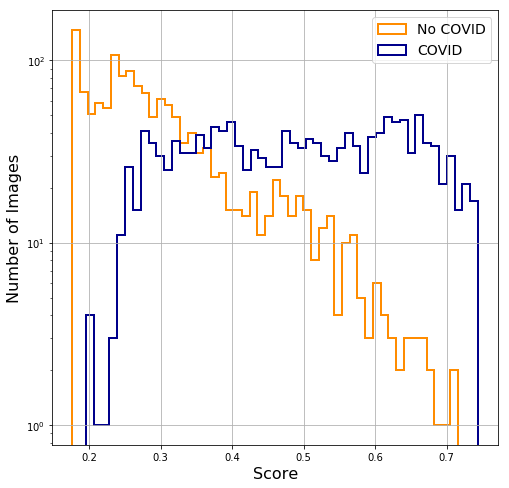

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(nocovid, 50, histtype='step', lw=2, color='darkorange', label='No COVID')
ax.hist(covid, 50, histtype='step', lw=2, color='darkblue', label='COVID')
plt.grid()
ax.set_ylabel('Number of Images', fontsize=16)
ax.set_xlabel('Score', fontsize=16)
plt.legend( loc='upper right', fontsize=14)
plt.yscale("log")
fig.savefig('Figures/histogram_Uncertainty_XGBr.eps', dpi=200)

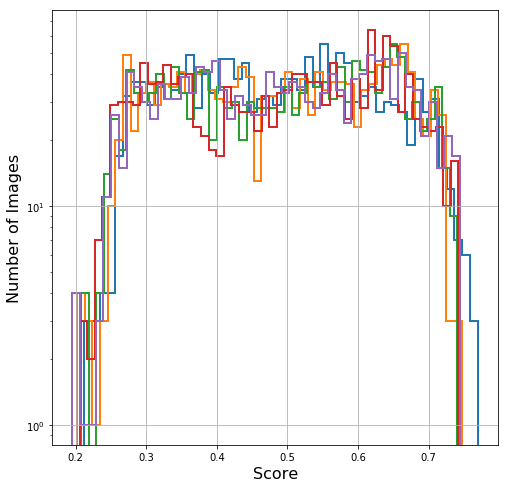

In [38]:
fig2, ax2 = plt.subplots(figsize=(8,8))
for pred in preds:
    nocovid = pred[np.where(Y_test == 0)]
    covid = pred[np.where(Y_test == 1)]
    #ax2.hist(nocovid, 50, histtype='step', lw=2, label='No COVID')
    ax2.hist(covid, 50, histtype='step', lw=2, label='COVID')
plt.grid()
ax2.set_ylabel('Number of Images', fontsize=16)
ax2.set_xlabel('Score', fontsize=16)
#plt.legend( loc='upper right', fontsize=14)
plt.yscale("log")
fig2.savefig('Figures/histograms_Covid_Uncertainty_XGBr.eps', dpi=200)

## Curva ROC

In [40]:
fpr, tpr, thresholds = roc_curve(Y_test, predictive_mean)
fpr_U, tpr_U, thr = roc_curve(Y_test, predictive_mean_up)
fpr_L, tpr_L, thr = roc_curve(Y_test, predictive_mean_down)
roc_auc = auc(fpr, tpr)
roc_auc_U = auc(fpr_U, tpr_U)
roc_auc_L = auc(fpr_L, tpr_L)

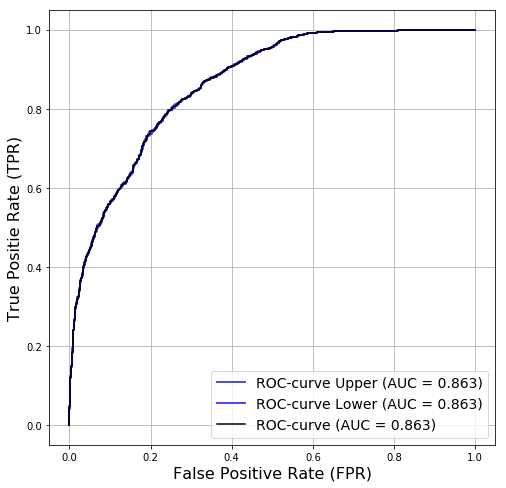

In [60]:
fig3, ax3 =plt.subplots(figsize=(8,8))
ax3.plot(fpr_U, tpr_U, color='blue',lw=2, label='ROC-curve Upper (AUC = %0.3f)' % (roc_auc_U), alpha=0.7)
ax3.plot(fpr_L, tpr_L, color='blue',lw=2, label='ROC-curve Lower (AUC = %0.3f)' % (roc_auc_L), alpha=0.7)
ax3.plot(fpr, tpr, color='k', label='ROC-curve (AUC = %0.3f)' % (roc_auc))
ax3.set_ylabel('True Positie Rate (TPR)', fontsize=16)
ax3.set_xlabel('False Positive Rate (FPR)', fontsize=16)
plt.grid()
plt.legend(loc="lower right", fontsize=14)
fig3.savefig('Figures/ROC')
plt.show()
